# Imports

In [3]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, UpSampling2D, Conv2DTranspose, Concatenate
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt

# Step 1 - Preparing dataset

In [5]:
pathname = 'V-01/'
sample_size = 50
original_size = (2016, 1512)
target_size = (512, 512)
learning_rate = 1e-4
num_classes = 18
batch_size = 8
epochs = 20

X_all = []
y_all = []

def one_hot_encode(masks, num_classes):
    masks_encoded = np.zeros((*masks.shape, num_classes), dtype=np.float32)
    for i in range(num_classes):
        masks_encoded[..., i] = (masks == i).astype(np.float32)
    return masks_encoded

def resize_image_and_mask(image, mask, target_size):
    image_resized = cv2.resize(image, target_size)
    mask_resized = cv2.resize(mask, target_size, interpolation=cv2.INTER_NEAREST)
    return image_resized, mask_resized

image_filenames = [img_name for img_name in os.listdir(f'{pathname}image') if ':' not in img_name]
np.random.shuffle(image_filenames)
selected_filenames = image_filenames[:sample_size]

for img_name in selected_filenames:
    img = np.asarray(cv2.imread(f'{pathname}/image/{img_name}')) / 255.0
    mask = np.asarray(cv2.imread(f'{pathname}/indexLabel/{img_name}'))
    mask = mask[:,:,0]
    
    img, mask = resize_image_and_mask(img, mask, target_size)
    X_all.append(img)
    y_all.append(mask)

X_all = np.asarray(X_all)
y_all = one_hot_encode(np.asarray(y_all), num_classes)

print(f"Shape of x_all: {X_all.shape}")
print(f"Shape of y_all: {y_all.shape}")

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

Shape of x_all: (50, 512, 512, 3)
Shape of y_all: (50, 512, 512, 18)


# Step 2 - Creating and compiling the model

In [7]:
def unet_model(shape, num_classes):
    def conv_block(inputs, filters, pool=True):
        x = Conv2D(filters, 3, padding="same")(inputs)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
    
        x = Conv2D(filters, 3, padding="same")(inputs)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
    
        if pool == True:
            p = MaxPooling2D((2, 2))(x)
            return x, p
        else:
            return x
        
    inputs = Input(shape)

    # Encoder Layer
    x1, p1 = conv_block(inputs, 16, pool=True)
    x2, p2 = conv_block(p1, 32, pool=True)
    x3, p3 = conv_block(p2, 48, pool=True)
    x4, p4 = conv_block(p3, 64, pool=True)

    # Bridge Layer
    b1 = conv_block(p4, 128, pool=False)

    # Decoder Layer
    u1 = UpSampling2D((2, 2), interpolation="bilinear")(b1)
    c1 = Concatenate()([u1, x4])
    x5 = conv_block(c1, 64, pool=False)

    u2 = UpSampling2D((2, 2), interpolation="bilinear")(x5)
    c2 = Concatenate()([u2, x3])
    x6 = conv_block(c2, 48, pool=False)
    
    u3 = UpSampling2D((2, 2), interpolation="bilinear")(x6)
    c3 = Concatenate()([u3, x2])
    x7 = conv_block(c3, 32, pool=False)
    
    u4 = UpSampling2D((2, 2), interpolation="bilinear")(x7)
    c4 = Concatenate()([u4, x1])
    x8 = conv_block(c4, 16, pool=False)

    # Output layer
    output = Conv2D(num_classes, 1, padding="same", activation="softmax")(x8)
    return Model(inputs, output)

model = unet_model((512, 512, 3), num_classes)
print(model.summary())

model.compile(loss="categorical_crossentropy",
              optimizer=Adam(learning_rate),
              metrics=[MeanIoU(num_classes=18)])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 512, 512, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 512, 512, 16  64         ['conv2d_1[0][0]']               
 rmalization)                   )                                                             

# Step 3 - Training the model

In [9]:
print(y_train.shape)

model_file="models/UNet_model.h5"

callbacks = [
    ModelCheckpoint(model_file, verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.1, verbose=1, min_lr=1e-6),
    EarlyStopping(monitor="val_loss", patience=5, verbose=1)
]

history = model.fit(X_train, y_train, 
          validation_data=(X_val, y_val),
          batch_size=batch_size, 
          epochs=epochs,
          steps_per_epoch = np.ceil(len(X_train) / batch_size),
          verbose=1,
          validation_steps = np.ceil(len(X_val) / batch_size),
          shuffle=True,
          callbacks=callbacks)

(32, 512, 512, 18)
Epoch 1/20
4/4 [==============================] - ETA: 0s - loss: 2.4126 - mean_io_u: 0.4526
Epoch 1: val_loss improved from inf to 2.55599, saving model to models\UNet_model.h5
4/4 [==============================] - 39s 9s/step - loss: 2.4126 - mean_io_u: 0.4526 - val_loss: 2.5560 - val_mean_io_u: 0.4510 - lr: 1.0000e-04
Epoch 2/20
4/4 [==============================] - ETA: 0s - loss: 2.1958 - mean_io_u: 0.4526
Epoch 2: val_loss improved from 2.55599 to 2.54546, saving model to models\UNet_model.h5
4/4 [==============================] - 35s 9s/step - loss: 2.1958 - mean_io_u: 0.4526 - val_loss: 2.5455 - val_mean_io_u: 0.4510 - lr: 1.0000e-04
Epoch 3/20
4/4 [==============================] - ETA: 0s - loss: 2.0388 - mean_io_u: 0.4526
Epoch 3: val_loss improved from 2.54546 to 2.53884, saving model to models\UNet_model.h5
4/4 [==============================] - 39s 11s/step - loss: 2.0388 - mean_io_u: 0.4526 - val_loss: 2.5388 - val_mean_io_u: 0.4510 - lr: 1.0000e-04


# Step 4 - Predicting using the trained model

1/1 [==============================] - 0s 207ms/step


TypeError: src data type = 17 is not supported

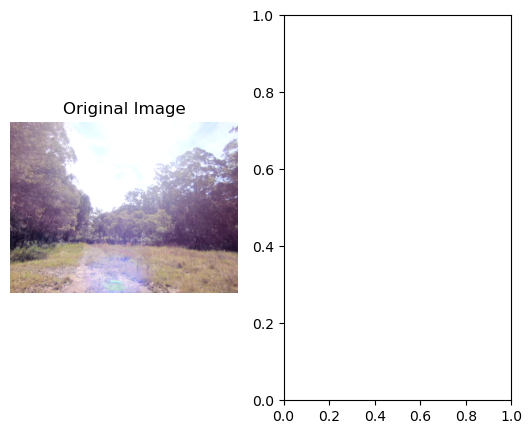

In [79]:
test_img = '1623378313-826275117.png'
img = cv2.imread('V-01/image/' + test_img) / 255.0
img_resized = cv2.resize(img, target_size)

colours = [[0, 0, 0], 
           [75, 25, 230], 
           [75, 180, 60], 
           [25, 225, 255], 
           [200, 130, 0], 
           [180, 30, 145], 
           [240, 240, 70], 
           [230, 50, 240], 
           [60, 245, 210], 
           [75, 25, 230], 
           [128, 128, 0], 
           [40, 110, 170], 
           [200, 250, 255], 
           [0, 0, 128], 
           [195, 255, 170], 
           [0, 128, 128], 
           [190, 190, 250], 
           [128, 0, 0], 
           [128, 128, 128]]

y_pred = model.predict(np.expand_dims(img_resized, axis=0))
y_pred_labels = np.argmax(y_pred, axis=-1)[0]
y_pred_resized = cv2.resize(y_pred_labels, original_size, interpolation=cv2.INTER_NEAREST)

result = np.array([[colours[num] for num in row] for row in y_pred_resized])
original = np.asarray(cv2.imread('V-01/image/' + test_img))
actual = np.asarray(cv2.imread('V-01/label/' + test_img))

def display_single_prediction(original, actual, predicted):
    
    plt.figure(figsize=(10, 5))

    # Original image
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    
    # Original image
    plt.subplot(1, 3, 2)
    plt.imshow(cv2.cvtColor(actual, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    
    # Predicted mask
    plt.subplot(1, 3, 3)
    plt.imshow(predicted, cmap='jet', vmin=0, vmax=num_classes-1)
    plt.axis('off')
    
    plt.show()

# Display predictions for the single test image
display_single_prediction(original, actual, y_pred_resized)